In [9]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelBinarizer

#patch for previous version
if not hasattr(scipy, 'interp'):
    scipy.interp = np.interp

import scikitplot as skplt


In [2]:
#import and filter the dataset
penguins = sns.load_dataset("penguins")
penguins = penguins[penguins['species'] != 'Gentoo']
#verify
print(penguins['species'].unique())

<StringArray>
['Adelie', 'Chinstrap']
Length: 2, dtype: str


In [3]:
#train test split 80/20
df = penguins.dropna()

#include only the metrics features
X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = df['species'].map({'Adelie': 0, 'Chinstrap': 1}) #map to binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [4]:
# train logistic
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# accuracy
lr_preds = lr_model.predict(X_test)
lr_predicted_probs = lr_model.predict_proba(X_test)
lr_acc = accuracy_score(y_test, lr_preds)

print(f"Logistic Regression Accuracy: {lr_acc:.2%}")

Logistic Regression Accuracy: 100.00%


In [5]:
# train Naive Beyes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# accuracy
nb_preds = nb_model.predict(X_test)
nb_predicted_probs = nb_model.predict_proba(X_test)
nb_acc = accuracy_score(y_test, nb_preds)

print(f"Naive Bayes Accuracy: {nb_acc:.2%}")

Naive Bayes Accuracy: 95.35%


In [15]:
# auc metrics 
# Logistic Regression AUC
lr_train_auc = roc_auc_score(y_train, lr_model.predict_proba(X_train)[:, 1])
lr_test_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

# Naive Bayes AUC
nb_train_auc = roc_auc_score(y_train, nb_model.predict_proba(X_train)[:, 1])
nb_test_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1])

print(f"LogReg Train AUC: {lr_train_auc:.4f} | Test AUC: {lr_test_auc:.4f}")
print(f"NB Train AUC:     {nb_train_auc:.4f} | Test AUC: {nb_test_auc:.4f}")

LogReg Train AUC: 0.9997 | Test AUC: 1.0000
NB Train AUC:     0.9769 | Test AUC: 0.9733


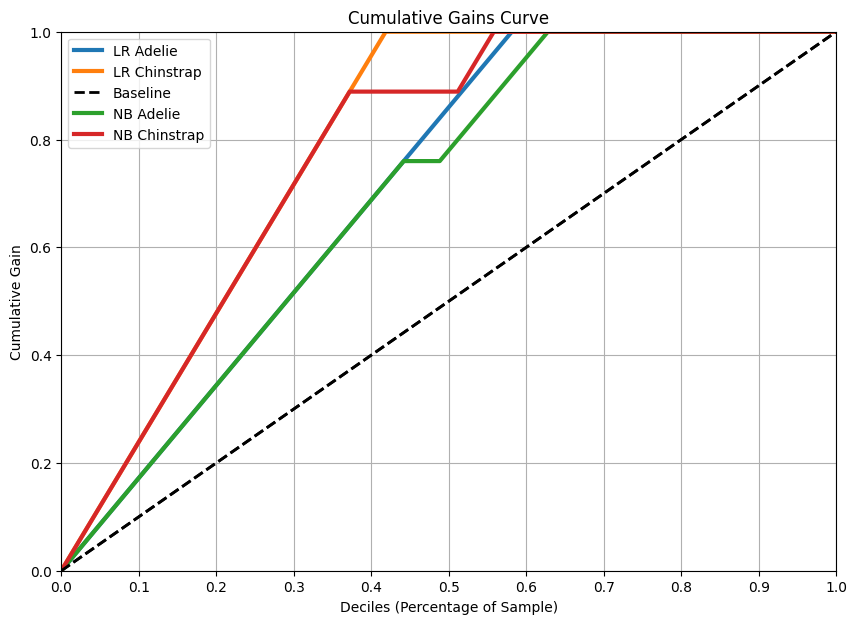

In [33]:
#combined plot

fig, ax = plt.subplots(figsize=(10, 7))

skplt.metrics.plot_cumulative_gain(y_test, lr_predicted_probs, ax=ax, title='Gain Comparison: LR vs Naive Bayes')
skplt.metrics.plot_cumulative_gain(y_test, nb_predicted_probs, ax=ax)

#labels
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel('Percentage of Sample')
ax.set_ylabel('Cumulative Gain')

plt.legend(['LR Adelie', 'LR Chinstrap', 'Baseline', 'NB Adelie', 'NB Chinstrap'])

#save and show
plt.savefig('combined_gain_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# MNIST extension



In [6]:
#load mnist dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# 2. Preprocess: Flatten 28x28 images to 784 vectors and normalize to [0, 1]
X_train = X_train.reshape(-1, 784).astype("float32") / 255.0
X_test = X_test.reshape(-1, 784).astype("float32") / 255.0

In [11]:
#lr 
model = models.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# auc
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)

# binarize conversion
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)


def get_per_category_metrics(X, y_true, model, label_binarizer):
    # Get predictions
    y_probs = model.predict(X)
    y_pred = np.argmax(y_probs, axis=1)
    
    # Binarize labels for AUC
    y_true_bin = label_binarizer.transform(y_true)
    
    # Calculate Per-Category AUC
    auc_per_class = roc_auc_score(y_true_bin, y_probs, multi_class='ovr', average=None)
    
    # Calculate Per-Category Accuracy
    cm = confusion_matrix(y_true, y_pred)
    acc_per_class = cm.diagonal() / cm.sum(axis=1)
    
    return acc_per_class, auc_per_class

# --- Execute for both sets ---
# Assuming lb is already fitted on your labels
train_acc, train_auc = get_per_category_metrics(X_train, y_train, model, lb)
test_acc, test_auc = get_per_category_metrics(X_test, y_test, model, lb)

# --- Comparison Table ---
print(f"{'Digit':<6} | {'Train Acc':<10} | {'Test Acc':<10} | {'Train AUC':<10} | {'Test AUC':<10}")
print("-" * 60)
for i in range(10):
    print(f"{i:<6} | {train_acc[i]:.3f}      | {test_acc[i]:.3f}      | {train_auc[i]:.4f}     | {test_auc[i]:.4f}")

2026-01-25 21:04:44.836826: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 188160000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
 198/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step

2026-01-25 21:05:08.607862: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
Digit  | Train Acc  | Test Acc   | Train AUC  | Test AUC  
------------------------------------------------------------
0      | 0.973      | 0.978      | 0.9989     | 0.9991
1      | 0.972      | 0.975      | 0.9989     | 0.9986
2      | 0.916      | 0.902      | 0.9910     | 0.9885
3      | 0.899      | 0.906      | 0.9921     | 0.9937
4      | 0.931      | 0.918      | 0.9963     | 0.9960
5      | 0.882      | 0.868      | 0.9911     | 0.9897
6      | 0.977      | 0.969      | 0.9989     | 0.9982
7      | 0.953      | 0.935      | 0.9966     | 0.9939
8      | 0.911      | 0.897      | 0.9925     | 0.9895
9      | 0.908      | 0.908      | 0.9937     | 0.9925


In [15]:
#naive bayes
# 3. Initialize and Train Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# 4. Predict probabilities and classes
y_pred = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)

# 5. Evaluate Accuracy and AUC
accuracy = accuracy_score(y_test, y_pred)

lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

def get_nb_metrics(X, y_true, model, label_binarizer):
    # 1. Get hard predictions and probability scores
    y_pred = model.predict(X)
    y_probs = model.predict_proba(X)
    
    # 2. Binarize labels for AUC
    y_true_bin = label_binarizer.transform(y_true)
    
    # 3. Per-Category AUC (Area Under Curve)
    auc_per_class = roc_auc_score(y_true_bin, y_probs, multi_class='ovr', average=None)
    
    # 4. Per-Category Accuracy (Recall)
    cm = confusion_matrix(y_true, y_pred)
    acc_per_class = cm.diagonal() / cm.sum(axis=1)
    
    return acc_per_class, auc_per_class

# --- Execute for Naive Bayes ---
# Ensure lb is already fitted on the training labels
train_acc_nb, train_auc_nb = get_nb_metrics(X_train, y_train, nb_model, lb)
test_acc_nb, test_auc_nb = get_nb_metrics(X_test, y_test, nb_model, lb)

# --- Display Results ---
print(f"{'Digit':<6} | {'Train Acc':<10} | {'Test Acc':<10} | {'Train AUC':<10} | {'Test AUC':<10}")
print("-" * 65)
for i in range(10):
    print(f"{i:<6} | {train_acc_nb[i]:.3f}      | {test_acc_nb[i]:.3f}      | {train_auc_nb[i]:.4f}     | {test_auc_nb[i]:.4f}")

Digit  | Train Acc  | Test Acc   | Train AUC  | Test AUC  
-----------------------------------------------------------------
0      | 0.905      | 0.931      | 0.9935     | 0.9964
1      | 0.936      | 0.935      | 0.9936     | 0.9956
2      | 0.828      | 0.831      | 0.9820     | 0.9815
3      | 0.808      | 0.844      | 0.9733     | 0.9788
4      | 0.742      | 0.744      | 0.9831     | 0.9829
5      | 0.661      | 0.657      | 0.9672     | 0.9694
6      | 0.914      | 0.897      | 0.9917     | 0.9921
7      | 0.822      | 0.838      | 0.9889     | 0.9839
8      | 0.770      | 0.797      | 0.9533     | 0.9596
9      | 0.828      | 0.853      | 0.9702     | 0.9722


In [68]:
#get metrics for both of the algorithms
def get_metrics(model, X, y_true, is_keras=False):
    if is_keras:
        # Keras returns probabilities directly from .predict()
        probs = model.predict(X, verbose=0)
        preds = np.argmax(probs, axis=1)
    else:
        # Sklearn requires explicit .predict_proba() for AUC
        probs = model.predict_proba(X)
        preds = model.predict(X)
    
    # Calculate Accuracy
    acc = accuracy_score(y_true, preds)
    
    # Calculate AUC (One-vs-Rest)
    lb = LabelBinarizer()
    y_bin = lb.fit_transform(y_true)
    auc = roc_auc_score(y_bin, probs, multi_class='ovr')
    
    return acc, auc



lr_train_acc, lr_train_auc = get_metrics(model, X_train, y_train, is_keras=True)
lr_test_acc, lr_test_auc = get_metrics(model, X_test, y_test, is_keras=True)

# For Naive Bayes (Sklearn)
nb_train_acc, nb_train_auc = get_metrics(nb_model, X_train, y_train)
nb_test_acc, nb_test_auc = get_metrics(nb_model, X_test, y_test)

# Print results in a clean format
results = [
    ["Linear Regression", lr_train_acc, lr_test_acc, lr_train_auc, lr_test_auc],
    ["Naive Bayes", nb_train_acc, nb_test_acc, nb_train_auc, nb_test_auc]
]

print(f"{'Model':<15} | {'Train Acc':<8} | {'Test Acc':<8} | {'Train AUC':<8} | {'Test AUC':<8}")
print("-" * 60)
for r in results:
    print(f"{r[0]:<15} | {r[1]:.4f}   | {r[2]:.4f}   | {r[3]:.4f}   | {r[4]:.4f}")

Model           | Train Acc | Test Acc | Train AUC | Test AUC
------------------------------------------------------------
Linear Regression | 0.9327   | 0.9259   | 0.9950   | 0.9942
Naive Bayes     | 0.8246   | 0.8357   | 0.9797   | 0.9812


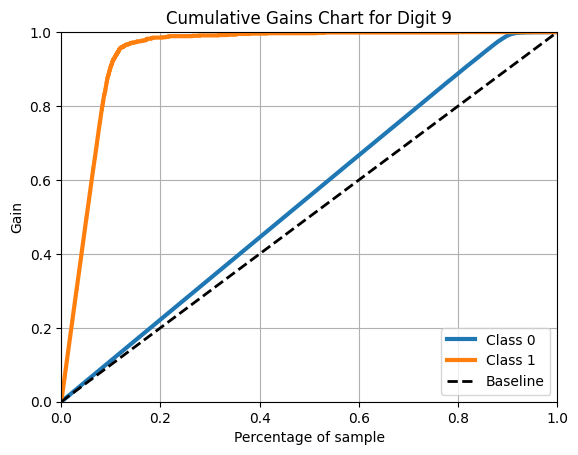

In [82]:
#plot the gains curves - lr keras
target_digit = 9
title = f"Cumulative Gains Chart for Digit {target_digit}"
y_test_binary = (y_test == target_digit).astype(int)

#class 0 -> probability that the digit is not the digit of interest
prob_target = y_probs[:, target_digit]
probs_binary = np.column_stack((1 - prob_target, prob_target)) 

# 4. Plot
skplt.metrics.plot_cumulative_gain(y_test_binary, probs_binary)
plt.title(title)
plt.savefig(title + '.png', dpi=300, bbox_inches='tight')
plt.show()

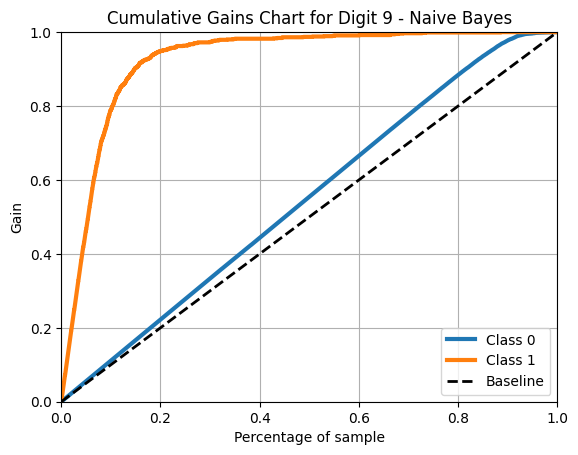

In [98]:
target_digit = 9
title = f"Cumulative Gains Chart for Digit {target_digit} - Naive Bayes"

y_test_binary = (y_test == target_digit).astype(int)
prob_target = y_prob[:, target_digit]

#class 0 -> probability that the digit is not the digit of interest
probs_binary = np.column_stack((1 - prob_target, prob_target))

skplt.metrics.plot_cumulative_gain(y_test_binary, probs_binary)
plt.title(title)
plt.savefig(title + '.png', dpi=300, bbox_inches='tight')
plt.show()